   Age  YearsAtCompany  WorkHoursPerWeek  BurnoutLevel  JobSatisfaction  \
0   50              14                47          3.37             5.06   
1   36               1                59          7.39             2.00   
2   29              13                59          7.10             7.17   
3   42              15                31          4.18             3.76   
4   40               6                34          8.28             2.34   

   StressLevel  ProductivityScore  SleepHours  PhysicalActivityHrs  \
0         9.47               4.16         7.0                  7.9   
1         5.65               3.74         7.2                  9.0   
2         5.70               8.80         5.2                  9.7   
3         6.40               4.69         8.7                  5.8   
4         3.41               2.12         4.2                  3.3   

   CommuteTime  ...  Department_Sales  Department_Support  RemoteWork_No  \
0          117  ...               0.0               

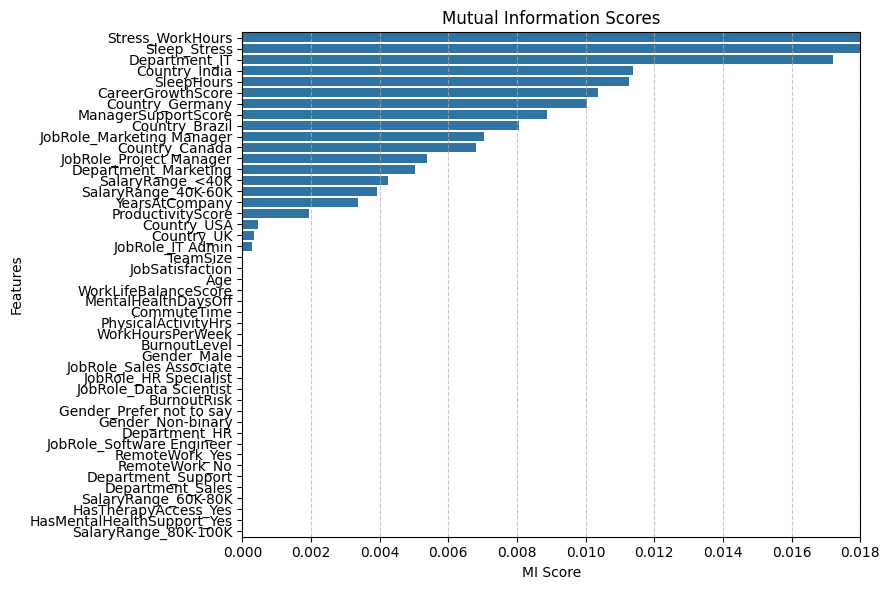

Mutual information plot saved as 'mutual_information_plot.png'

=== Model Performance ===
Linear - MSE: 6.6939, R²: -0.0108
Ridge - MSE: 6.6939, R²: -0.0108
Lasso - MSE: 6.6521, R²: -0.0045

Processed data saved to 'processed_data_simple.csv'

=== Summary ===
Best model: Lasso (MSE: 6.6521, R²: -0.0045)
Reason: It likely balances fit and generalization best.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load data
data = pd.read_csv('/content/drive/MyDrive/mental_health_workplace_survey.csv')

# Step 1: Encode categorical columns
cat_cols = ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork', 'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(data[cat_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_cols))
data_encoded = pd.concat([data.drop(columns=cat_cols + ['EmployeeID']), encoded_df], axis=1)
print(data_encoded.head())

# Step 2: Normalize numerical features
num_cols = ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction',
            'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs', 'CommuteTime',
            'ManagerSupportScore', 'MentalHealthDaysOff', 'WorkLifeBalanceScore',
            'TeamSize', 'CareerGrowthScore']
scaler = StandardScaler()
data_encoded[num_cols] = scaler.fit_transform(data_encoded[num_cols])
print(data_encoded.head())

# Step 3: Create interaction features
data_encoded['Stress_WorkHours'] = data_encoded['StressLevel'] * data_encoded['WorkHoursPerWeek']
data_encoded['Sleep_Stress'] = data_encoded['StressLevel'] * data_encoded['SleepHours']

# Step 4: Feature selection using mutual information
X = data_encoded.drop(columns=['StressLevel'])
y = data_encoded['StressLevel']
mi_scores = mutual_info_regression(X, y, random_state=42)

# Store in DataFrame for sorting
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Display feature selection results
print("\n=== Feature Selection ===")
print("Top 15 features by mutual information with StressLevel:")
for feature, mi in zip(mi_df['Feature'].head(15), mi_df['MI Score'].head(15)):
    print(f"{feature}: {mi:.6f}")
print("Additional features: Stress_WorkHours, Sleep_Stress")
selected_features = mi_df['Feature'].head(15).tolist() + ['Stress_WorkHours', 'Sleep_Stress']
print("Selected features:", selected_features)

# Plot top MI features with custom x-axis scale (1 cm = 0.002 units)
plt.figure(figsize=(9, 6))  # Adjusted to ~9 inches for x-axis to match 9 cm range (0 to 0.018)
sns.barplot(x='MI Score', y='Feature', data=mi_df)
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Features')
plt.xticks([0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018])
plt.xlim(0, 0.018)  # Set x-axis limit to match max MI score range with padding
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('mutual_information_plot.png', dpi=300)
plt.show()
print("Mutual information plot saved as 'mutual_information_plot.png'")

# Step 5: Prepare data
X_mi_selected = X[selected_features]
y = data_encoded['StressLevel']
X_train, X_test, y_train, y_test = train_test_split(X_mi_selected, y, test_size=0.2, random_state=42)

# Step 6: Train and evaluate models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}
results = {}
print("\n=== Model Performance ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}")

# Step 7: Save processed data
data_encoded.to_csv('processed_data_simple.csv', index=False)
print("\nProcessed data saved to 'processed_data_simple.csv'")

# Summary
best_model = min(results.items(), key=lambda x: x[1]['MSE'])
print("\n=== Summary ===")
print(f"Best model: {best_model[0]} (MSE: {best_model[1]['MSE']:.4f}, R²: {best_model[1]['R²']:.4f})")
print("Reason: It likely balances fit and generalization best.")
